In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis

%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
day_to_analyze = datetime.strptime("2020-10-14", "%Y-%m-%d")
env = "PAPER"

In [3]:
trades = analysis.load_trades(day_to_analyze, env)
algo_runs = analysis.load_runs(day_to_analyze, env)

[38620]2020-10-18 01:18:21.793767:db connection pool initialized


In [4]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_batch_revenue(x, trades, batch_id)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades, batch_id)
    )

    batch_time = (
        algo_runs.loc[algo_runs["batch_id"] == batch_id]
        .start_time.min()
        .tz_localize("utc")
        .astimezone(est)
    ) 
    
    env = algo_runs[algo_runs["batch_id"] == batch_id].algo_env.tolist()[0]
    print(
        f"[{env}] {batch_id}\n{batch_time}\nTotal revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

[PAPER] 2f84e134-af3a-4eaf-85df-57623127cdb2
2020-10-14 09:30:04.867483-04:00
Total revenues=$-152.74


,symbol,revenues,count
0,CRSR,-109.20,2
1,DFEN,-53.36,2
2,FEYE,22.10,4
3,FUV,15.44,3
4,INTZ,-16.72,2
5,KNDI,42.68,2
6,MUR,19.60,2
7,NEX,-100.95,2
8,NNDM,0.00,2
9,OIS,104.13,3


In [5]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

CRSR analysis with profit $-109.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2035.95,-2035.95,buy,2020-10-14 09:55:51.619317-04:00,19.39,105,2.81%,0.95%,"{'buy': {'avg': 19.0391, 'macd': [0.10720360464208056, 0.10955017822452007, 0.11014022672102541, 0.11253823934112361, 0.12270718667207348], 'vwap': 19.356, 'macd_signal': [0.10493727103413744, 0.10585985247221397, 0.10671592732197625, 0.10788038972580573, 0.11084574911505927]}, 'sell': None}",22.02,18.43
1,-109.20,1926.75,sell,2020-10-14 12:59:14.309518-04:00,18.35,105,-2.7%,,"{'buy': None, 'sell': {'avg': 18.9751, 'rsi': [42.63746141894914, 31.43526872392726, 28.3501082646126], 'vwap': 18.4028, 'reasons': 'stopped', 'movement': -0.05105724600309448, 'sell_macd': [-0.023817374325798113, -0.02208920988060825, -0.02094402706772769, -0.02653292322564127, -0.03299527187822804], 'sell_macd_signal': [-0.0265726325884174, -0.025675948046855572, -0.024729563851029996, -0.025090235725952252, -0.02667124295640741]}}",22.02,18.43


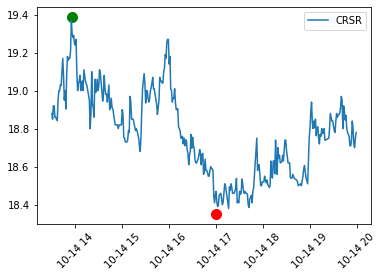

DFEN analysis with profit $-53.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2723.68,-2723.68,buy,2020-10-14 10:23:16.818094-04:00,11.74,232,3.07%,0.99%,"{'buy': {'avg': 11.5029, 'macd': [0.015191609433498954, 0.01534551090312597, 0.01781998628926651, 0.024206313314996564, 0.0305294320580618], 'vwap': 11.7391, 'macd_signal': [0.0283013717956129, 0.025710199617115514, 0.024132156951545712, 0.02414698822423588, 0.025423476991001066]}, 'sell': None}",12.95,11.34
1,-53.36,2670.32,sell,2020-10-14 15:46:13.386430-04:00,11.51,232,1.05%,,"{'buy': None, 'sell': {'liquidation': 1}}",12.95,11.34


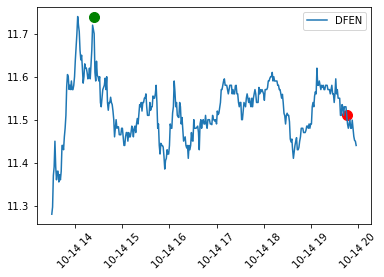

FEYE analysis with profit $22.10


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1875.90,-1875.90,buy,2020-10-14 10:12:45.526978-04:00,14.43,130,2.41%,1.14%,"{'buy': {'avg': 14.25, 'macd': [0.055363658859160836, 0.053559182196091015, 0.05991910296210534, 0.06540771207551188, 0.07015909856521141], 'vwap': 14.44, 'macd_signal': [0.05989200383841317, 0.05862543950994874, 0.05888417220038006, 0.060188880175406426, 0.06218292385336742]}, 'sell': None}",16.61,13.72
1,-109.30,1766.60,sell,2020-10-14 10:20:38.468038-04:00,14.60,121,3.62%,,"{'buy': None, 'sell': {'avg': 14.323, 'rsi': [69.61048672395795, 70.25976807087136, 79.6324318645243], 'vwap': 14.632, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014553014553014613, 'sell_macd': [0.04205266529486984, 0.04194405969687054, 0.04245756105301446, 0.04272187949867323, 0.05026911621608754], 'sell_macd_signal': [0.04008534642548814, 0.04045708907976462, 0.04085718347441459, 0.04123012267926632, 0.04303792138663056]}}",16.61,13.72
2,7.50,116.80,sell,2020-10-14 10:20:38.643215-04:00,14.60,8,3.62%,,"{'buy': None, 'sell': {'avg': 14.323, 'rsi': [69.61048672395795, 70.25976807087136, 79.6324318645243], 'vwap': 14.632, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014553014553014613, 'sell_macd': [0.04205266529486984, 0.04194405969687054, 0.04245756105301446, 0.04272187949867323, 0.05026911621608754], 'sell_macd_signal': [0.04008534642548814, 0.04045708907976462, 0.04085718347441459, 0.04123012267926632, 0.04303792138663056]}}",16.61,13.72
3,22.10,14.60,sell,2020-10-14 10:20:39.167207-04:00,14.60,1,3.62%,,"{'buy': None, 'sell': {'avg': 14.323, 'rsi': [69.61048672395795, 70.25976807087136, 79.6324318645243], 'vwap': 14.632, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.014553014553014613, 'sell_macd': [0.04205266529486984, 0.04194405969687054, 0.04245756105301446, 0.04272187949867323, 0.05026911621608754], 'sell_macd_signal': [0.04008534642548814, 0.04045708907976462, 0.04085718347441459, 0.04123012267926632, 0.04303792138663056]}}",16.61,13.72


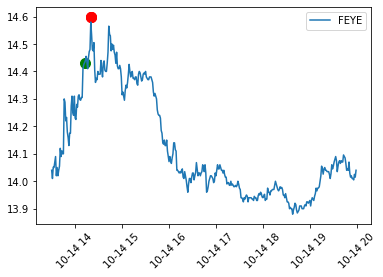

FUV analysis with profit $15.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-298.89,-298.89,buy,2020-10-14 09:59:06.213876-04:00,7.29,41,5.96%,3.56%,"{'buy': {'avg': 7.1248, 'macd': [0.0680846405613389, 0.0659690286031438, 0.06549019839540549, 0.07679720950449465, 0.08637623861270427], 'vwap': 7.2975, 'macd_signal': [0.08175504060703839, 0.07859783820625947, 0.07597631024408867, 0.07614049009616987, 0.07818763979947675]}, 'sell': None}",8.76,6.81
1,-1406.97,-1108.08,buy,2020-10-14 09:59:06.410054-04:00,7.29,152,5.96%,3.56%,"{'buy': {'avg': 7.1248, 'macd': [0.0680846405613389, 0.0659690286031438, 0.06549019839540549, 0.07679720950449465, 0.08637623861270427], 'vwap': 7.2975, 'macd_signal': [0.08175504060703839, 0.07859783820625947, 0.07597631024408867, 0.07614049009616987, 0.07818763979947675]}, 'sell': None}",8.76,6.81
2,15.44,1422.41,sell,2020-10-14 11:06:20.777365-04:00,7.37,193,7.12%,,"{'buy': None, 'sell': {'avg': 7.1439, 'rsi': [69.67752841295629, 77.08397328200188, 80.27862869027189], 'vwap': 7.3945, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01433470507544579, 'sell_macd': [0.015557124673381217, 0.01808324809460693, 0.022154470915113578, 0.030488482581545462, 0.03994240748290068], 'sell_macd_signal': [0.013640387870577269, 0.0145289599153832, 0.016054062115329275, 0.018940946208572514, 0.023141238463438147]}}",8.76,6.81


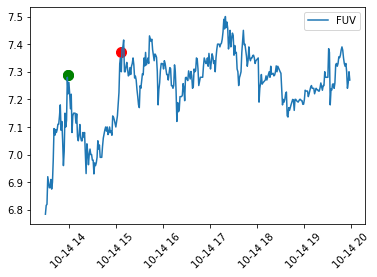

INTZ analysis with profit $-16.72


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1048.08,-1048.08,buy,2020-10-14 10:10:54.338045-04:00,11.91,88,7.3%,2.38%,"{'buy': {'avg': 11.3643, 'macd': [0.12618274925536532, 0.17283533863426825, 0.18827158001506916, 0.20859032662378496, 0.22452563719615704], 'vwap': 11.9025, 'macd_signal': [0.10672857528308013, 0.11994992795331776, 0.13361425836566804, 0.1486094720172914, 0.16379270505306454]}, 'sell': None}",15.11,10.84
1,-16.72,1031.36,sell,2020-10-14 10:14:38.128462-04:00,11.72,88,5.59%,,"{'buy': None, 'sell': {'avg': 11.5979, 'rsi': [73.13463226006259, 63.2582786189271, 80.59447980622693], 'vwap': 12.5329, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.07472712006717049, 'sell_macd': [0.1293812505485441, 0.139136594063066, 0.14441171116447116, 0.1375558061634301, 0.17239593465400205], 'sell_macd_signal': [0.09194652310184394, 0.10138453729408835, 0.10998997206816491, 0.11550313888721794, 0.12688169804057475]}}",15.11,10.84


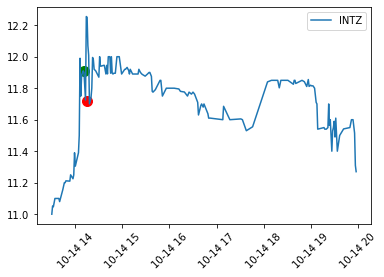

KNDI analysis with profit $42.68


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1584.98,-1584.98,buy,2020-10-14 10:11:06.196302-04:00,8.17,194,6.9%,4.53%,"{'buy': {'avg': 7.9889, 'macd': [0.07365470781867778, 0.08600032872571362, 0.09318507070443705, 0.1001453663207652, 0.10445733164614257], 'vwap': 8.1902, 'macd_signal': [0.08603317067323887, 0.08602660228373382, 0.08745829596787447, 0.08999571003845261, 0.0928880343599906]}, 'sell': None}",9.64,7.71
1,42.68,1627.66,sell,2020-10-14 11:04:23.834904-04:00,8.39,194,9.78%,,"{'buy': None, 'sell': {'avg': 8.0584, 'rsi': [59.62640610915225, 59.63699420572003, 79.84483420890683], 'vwap': 8.3935, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.033047735618115005, 'sell_macd': [0.01796981988152524, 0.0197737514145242, 0.020662870123166144, 0.021092535738691964, 0.03717938510483165], 'sell_macd_signal': [0.00957373181850623, 0.011613735737709824, 0.013423562614801089, 0.014957357239579264, 0.01940176281262974]}}",9.64,7.71


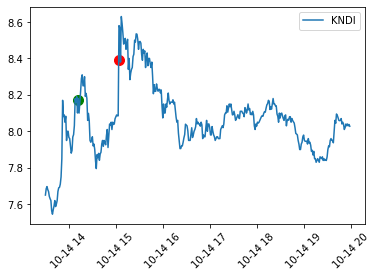

MUR analysis with profit $19.60


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2461.20,-2461.20,buy,2020-10-14 10:23:29.168527-04:00,8.79,280,2.09%,0.19%,"{'buy': {'avg': 8.6266, 'macd': [0.023791097211288914, 0.025971099923689067, 0.029768297491253648, 0.03280293037192372, 0.035205529576186834], 'vwap': 8.7923, 'macd_signal': [0.02282480003555924, 0.023454060013185205, 0.024716907508798895, 0.02633411208142386, 0.028108395580376457]}, 'sell': None}",9.80,8.45
1,19.60,2480.80,sell,2020-10-14 11:20:15.721372-04:00,8.86,280,2.9%,,"{'buy': None, 'sell': {'avg': 8.6719, 'rsi': [76.5247910477195, 76.5247910477195, 79.213429827977], 'vwap': 8.87, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.009101251422070543, 'sell_macd': [0.013543615795246211, 0.01520082322749694, 0.017593441704217838, 0.019229333482128297, 0.021293283783329287], 'sell_macd_signal': [0.008437412911478861, 0.009790094974682476, 0.011350764320589549, 0.012926478152897299, 0.014599839278983697]}}",9.80,8.45


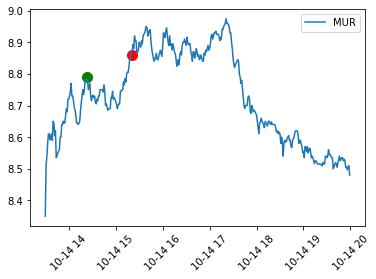

NEX analysis with profit $-100.95


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1460.41,-1460.41,buy,2020-10-14 09:48:09.348087-04:00,2.17,673,4.83%,2.26%,"{'buy': {'avg': 2.1168, 'macd': [0.013372054378935072, 0.014329200025404276, 0.014828055446137522, 0.01673310678208395, 0.01883269849221758], 'vwap': 2.16, 'macd_signal': [0.008644398533979933, 0.009781358832264801, 0.010790698155039346, 0.011979179880448266, 0.01334988360280213]}, 'sell': None}",2.58,2.02
1,-100.95,1359.46,sell,2020-10-14 15:15:12.318970-04:00,2.02,673,-2.42%,,"{'buy': None, 'sell': {'avg': 2.1261, 'rsi': [42.64990880617891, 30.44637098596682, 30.446370985966826], 'vwap': 2.0247, 'reasons': 'stopped', 'movement': -0.0691244239631336, 'sell_macd': [-0.0013690439147167055, -0.0015467914520264081, -0.0016652078258774239, -0.002774815288282717, -0.0033592520734258002], 'sell_macd_signal': [-0.001832606230886793, -0.001775443275114716, -0.0017533961852672576, -0.0019576800058703496, -0.00223799441938144]}}",2.58,2.02


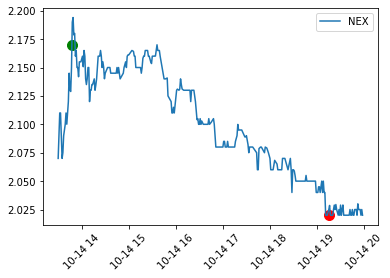

NNDM analysis with profit $0.00


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1300.00,-1300.00,buy,2020-10-14 10:05:24.610007-04:00,3.25,400,4.5%,0.96%,"{'buy': {'avg': 3.1401, 'macd': [0.022506969920723652, 0.02138711986782127, 0.021861458203948025, 0.02357939897209338, 0.027847536052867383], 'vwap': 3.241, 'macd_signal': [0.026014248812939712, 0.025088823023916025, 0.024443350059922424, 0.024270559842356616, 0.02498595508445877]}, 'sell': None}",3.95,3.02
1,0.00,1300.00,sell,2020-10-14 10:59:10.164008-04:00,3.25,400,4.5%,,"{'buy': None, 'sell': {'avg': 3.1721, 'rsi': [60.99092281767226, 54.4242612597428, 58.11953288109726], 'vwap': 3.2512, 'reasons': 'bail post whipsawed', 'movement': 0.0015384615384615057, 'sell_macd': [0.011520013775228044, 0.011826246968044352, 0.01184894494987443, 0.01064781422208183, 0.01018657191182637], 'sell_macd_signal': [0.010384093133096482, 0.010672523900086056, 0.01090780811004373, 0.01085580933245135, 0.010721961848326354]}}",3.95,3.02


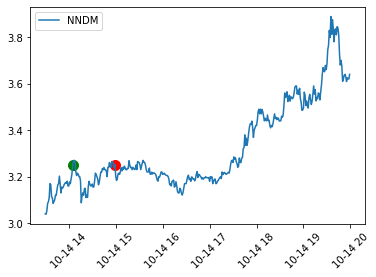

OIS analysis with profit $104.13


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2415.70,-2415.70,buy,2020-10-14 10:15:08.697245-04:00,2.90,833,4.69%,2.93%,"{'buy': {'avg': 2.8511, 'macd': [0.012217117753857476, 0.012392331797041578, 0.01478154699558143, 0.015288407370555923, 0.016707874531911582], 'vwap': 2.8928, 'macd_signal': [0.014754865233191352, 0.014282358545961398, 0.014382196235885405, 0.014563438462819508, 0.014992325676637924]}, 'sell': None}",3.24,2.79
1,-1159.38,1256.32,sell,2020-10-14 11:19:09.843235-04:00,3.02,416,9.03%,,"{'buy': None, 'sell': {'avg': 2.8942, 'rsi': [74.5704300341541, 74.5704300341541, 77.04978667432194], 'vwap': 3.0178, 'reasons': 'scale-out', 'movement': 0.04137931034482763, 'sell_macd': [0.011495014364268918, 0.011303515505541206, 0.012046457751914819, 0.012468926284778803, 0.013041383241753746], 'sell_macd_signal': [0.011057253583607474, 0.01110650596799422, 0.01129449632477834, 0.011529382316778433, 0.011831782501773495]}}",3.24,2.79
2,104.13,1263.51,sell,2020-10-14 11:19:46.830772-04:00,3.03,417,9.39%,,"{'buy': None, 'sell': {'avg': 2.8962, 'rsi': [74.5704300341541, 74.5704300341541, 79.08862409023408], 'vwap': 3.0311, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0033112582781456247, 'sell_macd': [0.011495014364268918, 0.011303515505541206, 0.012046457751914819, 0.012468926284778803, 0.013732292332662599], 'sell_macd_signal': [0.011057253583607474, 0.01110650596799422, 0.01129449632477834, 0.011529382316778433, 0.011969964319955267]}}",3.24,2.79


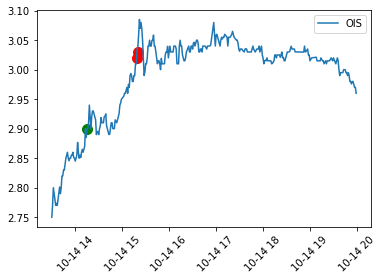

PAA analysis with profit $7.88


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2734.36,-2734.36,buy,2020-10-14 10:21:40.085190-04:00,6.94,394,3.12%,1.7%,"{'buy': {'avg': 6.8441, 'macd': [0.0016103261971496252, 0.004002853480130852, 0.00503400330605519, 0.008576539456781163, 0.012450873598154999], 'vwap': 6.9384, 'macd_signal': [0.004592970705756598, 0.004474947260631449, 0.004586758469716197, 0.00538471466712919, 0.006797946453334352]}, 'sell': None}",7.66,6.70
1,7.88,2742.24,sell,2020-10-14 11:14:29.188724-04:00,6.96,394,3.42%,,"{'buy': None, 'sell': {'avg': 6.863, 'rsi': [60.981344904879265, 60.98134490487928, 60.98134490487928], 'vwap': 6.96, 'reasons': 'bail post whipsawed', 'movement': 0.0028818443804033964, 'sell_macd': [0.013887592109036895, 0.012883507202315236, 0.011933785103541261, 0.011038757687567902, 0.010197973237620062], 'sell_macd_signal': [0.010807627211072136, 0.011222803209320755, 0.011364999588164856, 0.011299751208045465, 0.011079395613960385]}}",7.66,6.70


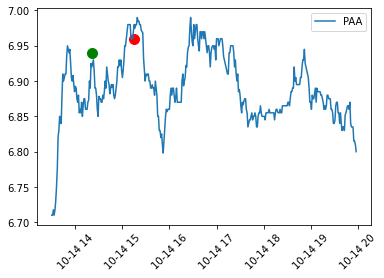

PEIX analysis with profit $19.04


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2244.34,-2244.34,buy,2020-10-14 10:25:32.116192-04:00,9.43,238,3.97%,2.96%,"{'buy': {'avg': 9.3388, 'macd': [-0.006282913194866069, -0.0033305675570218796, 0.0014136413336753861, 0.004931028455063213, 0.011802701801391535], 'vwap': 9.4469, 'macd_signal': [-0.00018716799670025186, -0.0008158479087645774, -0.00036995006027658474, 0.000690245642791375, 0.002912736874511407]}, 'sell': None}",10.63,9.05
1,19.04,2263.38,sell,2020-10-14 10:52:35.916900-04:00,9.51,238,4.85%,,"{'buy': None, 'sell': {'avg': 9.3622, 'rsi': [56.702374608544126, 52.928479761492376, 54.38169472378984], 'vwap': 9.49, 'reasons': 'bail post whipsawed', 'movement': 0.006362672322375451, 'sell_macd': [0.023236673049288115, 0.02326585444090945, 0.021557867805276132, 0.018778165650168432, 0.01688777220917359], 'sell_macd_signal': [0.02018673117110136, 0.02080255582506298, 0.02095361822110561, 0.020518527706918175, 0.01979237660736926]}}",10.63,9.05


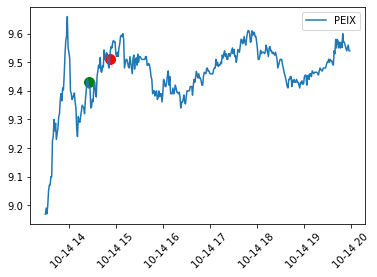

PTEN analysis with profit $19.10


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2798.15,-2798.15,buy,2020-10-14 10:15:38.044352-04:00,2.93,955,3.72%,1.64%,"{'buy': {'avg': 2.8712, 'macd': [0.010269851829790788, 0.009765786713242797, 0.011253874878759618, 0.011892646234890947, 0.013454160588157293], 'vwap': 2.9259, 'macd_signal': [0.012186722616632936, 0.011702535435954908, 0.01161280332451585, 0.01166877190659087, 0.012025849642904155]}, 'sell': None}",3.23,2.83
1,19.10,2817.25,sell,2020-10-14 11:28:15.932853-04:00,2.95,955,4.42%,,"{'buy': None, 'sell': {'avg': 2.8993, 'rsi': [64.8012370866567, 57.62271222160695, 54.3790317205138], 'vwap': 2.94, 'reasons': 'bail post whipsawed', 'movement': 0.0034129692832763777, 'sell_macd': [0.009592939262882627, 0.009398851552562704, 0.009125551368514007, 0.00827459601252123, 0.00724431137132564], 'sell_macd_signal': [0.0067519157392308005, 0.007281302901897181, 0.007650152595220546, 0.007775041278680683, 0.007668895297209674]}}",3.23,2.83


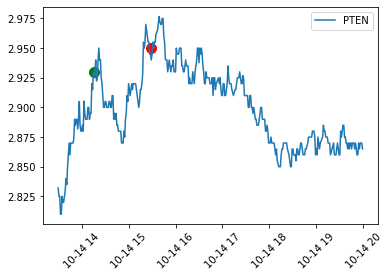

USAS analysis with profit $60.36


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2806.74,-2806.74,buy,2020-10-14 10:06:40.172999-04:00,2.79,1006,1.82%,0.34%,"{'buy': {'avg': 2.7494, 'macd': [0.009771621661465613, 0.010590640577464505, 0.01151049140250704, 0.012809970067112708, 0.013769846854856382], 'vwap': 2.79, 'macd_signal': [0.011045778780237384, 0.01095475113968281, 0.011065899192247656, 0.011414713367220667, 0.01188574006474781]}, 'sell': None}",3.07,2.70
1,60.36,2867.10,sell,2020-10-14 11:06:09.795382-04:00,2.85,1006,4.01%,,"{'buy': None, 'sell': {'avg': 2.7778, 'rsi': [76.87831420611649, 77.90009012702306, 79.14095714569213], 'vwap': 2.855, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.023297491039426504, 'sell_macd': [0.006929992999342716, 0.007648686900299406, 0.008940543356885211, 0.01003886600673276, 0.011024067214318478], 'sell_macd_signal': [0.005238462081310254, 0.0057205070451080845, 0.0063645143074635094, 0.00709938464731736, 0.007884321160717583]}}",3.07,2.70


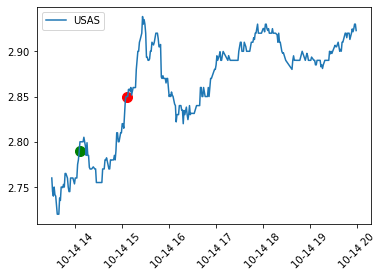

VOXX analysis with profit $-134.40


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,7062.72,7062.72,sell,2020-10-14 10:28:10.955261-04:00,10.51,672,3.03%,,"{'buy': None, 'sell': {'avg': 10.5688, 'vwap': 10.5031, 'vwap_series': [10.60545010685713, 10.628328719370375, 10.635381333349901, 10.642372634986538, 10.639721243890301]}}",10.08,10.64
1,-134.40,-7197.12,buy,2020-10-14 10:37:22.895221-04:00,10.71,672,4.99%,,"{'buy': {'reason': 'stopped', 'close_5m': [10.8301, 10.75, 10.55, 10.5201, 10.65]}, 'sell': None}",10.08,10.64


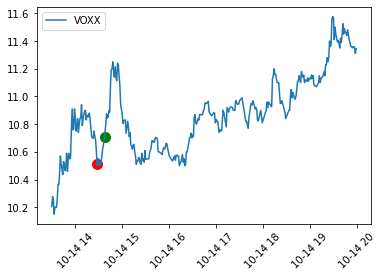

ZVO analysis with profit $-48.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1795.74,-1795.74,buy,2020-10-14 09:47:48.993641-04:00,5.19,346,3.8%,1.06%,"{'buy': {'avg': 5.0529, 'macd': [0.03033689448438892, 0.03692584423645773, 0.04010378670048276, 0.04293432524978513, 0.051044469979298235], 'vwap': 5.1769, 'macd_signal': [0.027769369215658233, 0.02960066421981813, 0.031701288715951056, 0.033947896022717874, 0.03736721081403395]}, 'sell': None}",6.01,4.92
1,-48.44,1747.30,sell,2020-10-14 15:47:13.449036-04:00,5.05,346,1.0%,,"{'buy': None, 'sell': {'liquidation': 1}}",6.01,4.92


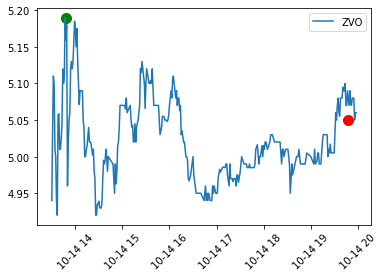

In [6]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(
        hour=9, minute=30, second=0, microsecond=0, tzinfo=None
    )
    end_date = start_date.replace(hour=16, minute=0, tzinfo=None)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        start_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
        end_index = minute_history[symbol]["close"].index.get_loc(
            end_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = float(minute_history[symbol]["close"][cool_minute_history_index])
    plt.plot(
        minute_history[symbol]["close"][start_index:end_index],
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()